In [4]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
pd.options.mode.chained_assignment = None

In [5]:
def ecdf(data):
    """
    Takes a dataset and creates x and y for ECDF plot
    """
    n=len(data)
    x=np.sort(data)
    y=np.arange(1, n+1)/n
    return x,y


In [6]:
#import cleaned H1B dataset
#full dataset can be found: https://www.kaggle.com/nsharan/h-1b-visa/data
#A description of cleanup can be found: https://github.com/Liptoni/Springboard/blob/master/H1B_Capstone/H1B_Data_Wrangling.docx
hb_data = pd.read_csv('h1b_clean.csv', index_col='CASE_NUMBER')

#need to create these in order to join with census data
hb_data['lat_round'] = hb_data['lat'].apply(lambda x: round(x, 4))
hb_data['lon_round'] = hb_data['lon'].apply(lambda x: round(x, 4))

C:\Users\Ian\AppData\Roaming\Python\Python36\site-packages\numpy\lib\arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
#import census data
census_cols = ['ID1', 'ID', 'lat', 'lon', 'block_fips', 'block_pop_2015', 'county_fips', 'county_name', 'state_code', 'state_fips', 'state_name', 'county_pop', 'GEONAME']
census_data = pd.read_csv('county_pop.csv', header=0, names=census_cols)
census_data['lat_round'] = census_data['lat'].apply(lambda x: round(x, 4))
census_data['lon_round'] = census_data['lon'].apply(lambda x: round(x, 4))
census_data = census_data[['ID', 'lat_round', 'lon_round', 'block_fips', 'block_pop_2015', 'county_fips', 'county_name', 'county_pop', 'state_code', 'state_fips', 'state_name']]


## Wages for Certified and Denied Applications

Set up a hypothesis test to determine if the average wage for applications that were denied is the same as applications that were certified:

$H_0$: certified = denied

$H_A$: certified != denied

In [8]:
#filter data to split between certified and denied applications. Remove records where wage is 0
cert_filter = (hb_data.CERTIFIED == 'certified') & (hb_data.PREVAILING_WAGE!= 0) & (hb_data.PREVAILING_WAGE < 1e+09)
den_filter = (hb_data.CERTIFIED == 'denied') & (hb_data.PREVAILING_WAGE!= 0) & (hb_data.PREVAILING_WAGE < 1e+09)

While I will be doing the analysis using the Prevailing Wage, it is easier to visualize the relationship by plotting the ECDF of the Log of the Prevailing Wage. This next step uses LOG_WAGE but then I switch back to using PREVAILING_WAGE for the actual t-test.

In [9]:
cert_wage = hb_data[cert_filter]['LOG_WAGE'].dropna()
den_wage = hb_data[den_filter]['LOG_WAGE'].dropna()

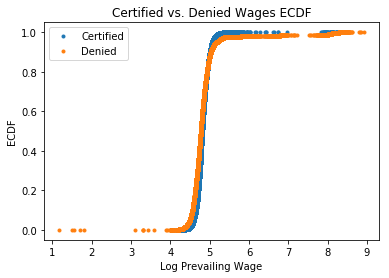

In [7]:
#create ECDF to visually compare these two datsets
cert_x, cert_y = ecdf(cert_wage)
den_x, den_y = ecdf(den_wage)

plt.plot(cert_x, cert_y, marker='.', linestyle='none')
plt.plot(den_x, den_y, marker='.', linestyle='none')

plt.xlabel('Log Prevailing Wage')
plt.ylabel("ECDF")
plt.title("Certified vs. Denied Wages ECDF")
plt.legend(['Certified', 'Denied'])
plt.show()

In [10]:
#use prevailing wage for statistical analysis
cert_wage = hb_data[cert_filter]['PREVAILING_WAGE'].dropna()
den_wage = hb_data[den_filter]['PREVAILING_WAGE'].dropna()

In [11]:
print('Certified Mean =', round(cert_wage.mean(), 2), '\t n=', len(cert_wage))
print('Denied Mean =', round(den_wage.mean(),2), '\t n=', len(den_wage))

Certified Mean = 72553.44 	 n= 2818282
Denied Mean = 2160933.65 	 n= 94265


In [12]:
#perform t-test to compare means of wages for certified and denied samples 

t, p = stats.ttest_ind(cert_wage, den_wage, equal_var=False)
print('p-value:',p)

p-value: 7.713352254522439e-281


Based on this p-value we would reject the null hypothesis that the average wage for certified and denied applications are the same.

## Wages for Full-time and Part-time Applications

Set up a hypothesis test to determine if the average wage for applications for full-time positions is the same as the average wage of applications for part-time positions:

$H_0$: full-time = part-time

$H_A$: full-time != part-time

In [13]:
#filter to split data into full-time and part-time position applications. Remove records with a 0 wage
ft_filter = (hb_data.PREVAILING_WAGE != 0) & (hb_data.FULL_TIME_POSITION == 'Y')
pt_filter = (hb_data.PREVAILING_WAGE != 0) & (hb_data.FULL_TIME_POSITION == 'N')

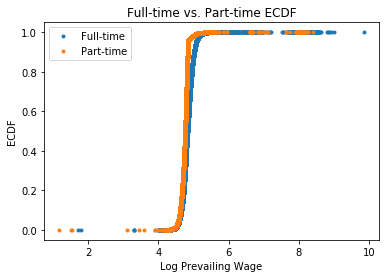

In [12]:
ft_wage = hb_data[ft_filter]['LOG_WAGE'].dropna()
pt_wage = hb_data[pt_filter]['LOG_WAGE'].dropna()

#create ECDF
ft_x, ft_y = ecdf(ft_wage)
pt_x, pt_y = ecdf(pt_wage)

plt.plot(ft_x, ft_y, marker='.', linestyle='none')
plt.plot(pt_x, pt_y, marker='.', linestyle='none')

plt.xlabel('Log Prevailing Wage')
plt.ylabel("ECDF")
plt.title("Full-time vs. Part-time ECDF")
plt.legend(['Full-time', 'Part-time'])
plt.show()

As with the previous section, it is easier to visualize the relationship by using the log of the prevailing wage. The actual analysis is done using the native prevailing wage variable. 

In [13]:
ft_wage = hb_data[ft_filter]['PREVAILING_WAGE'].dropna()
pt_wage = hb_data[pt_filter]['PREVAILING_WAGE'].dropna()

In [14]:
print('Full-time Mean =', round(ft_wage.mean(),2), '\t n=', len(ft_wage))
print('Part-time Mean =', round(pt_wage.mean(),2), '\t n=', len(pt_wage))

Full-time Mean = 155125.41 	 n= 2501021
Part-time Mean = 68549.35 	 n= 411528


In [15]:
t,p=stats.ttest_ind(ft_wage, pt_wage, equal_var=False)
print('p-value:', p)

p-value: 4.664149817679915e-102


With such a small p-value, we would reject the null hypothesis that wages for full-time and part-time positions are the same.

## County Population of Certified and Denied Applications

Here I set up a hypothesis test to determine if there is a difference in the population of counties for applications that were certified or denied. The county corresponds to the block of the potential employer's location.

$H_0$: Certified = Denied

$H_A$: Certified != Denied

In [14]:
#merge census data with h1b data
hb_census = hb_data.merge(census_data, how='left', left_on=['lat_round', 'lon_round'], right_on=['lat_round', 'lon_round'])
hb_census = hb_census[['FULL_TIME_POSITION', 'PREVAILING_WAGE', 'LOG_WAGE', 'CERTIFIED', 'county_pop']]

print(hb_census.head())

  FULL_TIME_POSITION  PREVAILING_WAGE  LOG_WAGE  CERTIFIED  county_pop
0                  N          36067.0  4.557110  certified    364709.0
1                  Y         242674.0  5.385023  certified    939585.0
2                  Y         193066.0  5.285706  certified    677983.0
3                  Y         220314.0  5.343042  certified    693060.0
4                  Y         225000.0  5.352183  certified   2712945.0


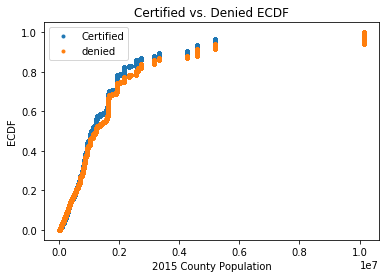

In [15]:
#separate certified and denied into two datasets with corresponding county populations
cert_filter = (hb_census.CERTIFIED=='certified')&(hb_census.county_pop.notnull())
den_filter = (hb_census.CERTIFIED=='denied')&(hb_census.county_pop.notnull())
cert_pop = hb_census[cert_filter]['county_pop']
den_pop = hb_census[den_filter]['county_pop']

#create ECDF plots
cert_x, cert_y = ecdf(cert_pop)
den_x, den_y = ecdf(den_pop)

plt.plot(cert_x, cert_y, marker='.', linestyle='none')
plt.plot(den_x, den_y, marker='.', linestyle='none')

plt.xlabel('2015 County Population')
plt.ylabel("ECDF")
plt.title("Certified vs. Denied ECDF")
plt.legend(['Certified', 'denied'])
plt.show()

In [18]:
#show mean populations for the two samples
print('Certified Mean =', round(cert_pop.mean(),0), '\t n=', len(cert_pop))
print('Denied Mean =', round(den_pop.mean(),0), '\t n=', len(den_pop))

Certified Mean = 1720650.0 	 n= 2721739
Denied Mean = 1993234.0 	 n= 85107


In [19]:
#run t-test comparing means of two samples
t,p=stats.ttest_ind(cert_pop, den_pop, equal_var=False)
print('p-value:', p)

p-value: 3.424243166084512e-240


Based on the results of the t-test I would reject the null hypothesis that the county population for applications that were certified and denied are the same.

## County Population vs. Prevailing Wage

Here I want to explore the data to determine if there is a correlation between county population and prevailing wage.

In [20]:
def get_least_squares(x, y):
    """
    Takes an x-data array and y-data array
    Returns x and y data for least squares line
    """
    slope, intercept = np.polyfit(x, y, 1)
    ls_x = np.array([0,x.max()])
    ls_y = slope*ls_x + intercept
    return ls_x, ls_y

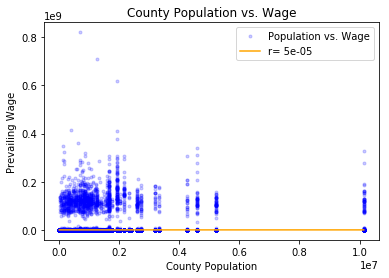

r = 4.822486900706989e-05 	 p-value: 0.9356064258794068


In [24]:
#get a clean dataset for making the correlation plot
fltr = (hb_census.PREVAILING_WAGE.notnull()) & (hb_census.PREVAILING_WAGE != 0) & (hb_census.PREVAILING_WAGE < 1e+09) & (hb_census.county_pop.notnull())
clean_hb_census = hb_census[fltr]

#separate out the parameters
county_pop = clean_hb_census['county_pop']
wages = clean_hb_census['PREVAILING_WAGE']

#get the least squares line and Pearson R
pop_wage_x, pop_wage_y = get_least_squares(county_pop, wages)
pop_wage_r, pop_wage_p = stats.pearsonr(county_pop, wages)

#make the plot
plot_label = "r= " + str(round(pop_wage_r, 5))
plt.xlabel('County Population')
plt.ylabel('Prevailing Wage')
plt.title('County Population vs. Wage')
plt.plot(county_pop, wages, linestyle='none', marker = '.', alpha=0.2, color='b', label='Population vs. Wage')
plt.plot(pop_wage_x, pop_wage_y, color='orange', label=plot_label)
plt.legend()
plt.show()

print("r =", pop_wage_r, '\t p-value:', pop_wage_p)

A Pearson-r of 0.00005 indicates that there is essentially no relationship between county population and prevailing wage and the p-value of 0.93 indicates that correlation coefficient is not significantly different from 0.